<a href="https://colab.research.google.com/github/lanyu0322/phd_semester1/blob/master/gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:

# -- mount google drive
from google.colab import drive
drive.mount("/content/drive")

# -- install geopandas
!pip install geopandas

Mounted at /content/drive


**Important import**

In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
from shapely.geometry import Point

import pyproj
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import statistics

**Define the function**

In [0]:
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)
cam_len = len(camera)

# -- define helper function for integrating within a circle
def integrate_geodata(geo, vals, lat, lon, rad):
  
  # -- convert lat/lon to NY State Plane
  ll_nyspd = pyproj.Proj(init="epsg:2263", preserve_units=True)(lon, lat)
  
  # -- define a circle
  circ = Point(ll_nyspd[0], ll_nyspd[1]).buffer(rad)
  
  # -- calculate the intersection of the circle with the geometry
  inter = geo.intersection(circ)
  
  # -- determine the overlap fraction
  frac = inter.area / geo.area
  return (frac * vals).sum() 

def convert_to_nyc(data):
  if (data.geometry.crs["init"] != "epsg:2263"):
    data.geometry = data.geometry.to_crs(epsg=2263)

**1.get the park area within 500 ft**

init park epsg:  {'init': 'epsg:4326'}
converted park epsg:  {'init': 'epsg:2263', 'no_defs': True}


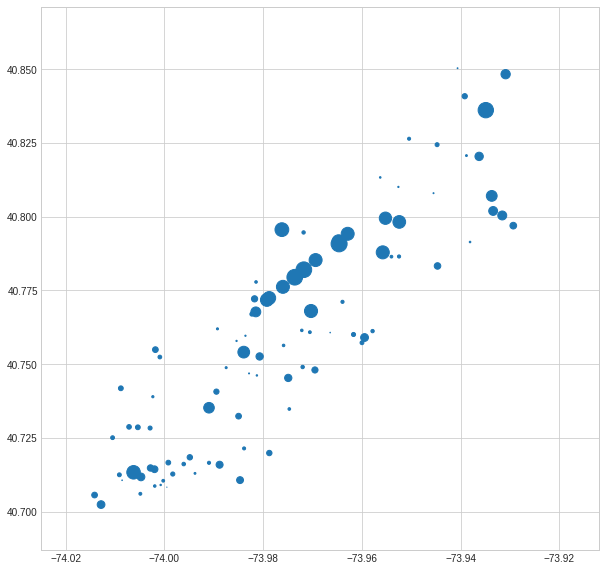

In [47]:
# for each camera:
park_fname = os.path.join("drive", "My Drive", "lwir", "data", "parks", "properties", "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp")
park_data = gp.read_file(park_fname)
print("init park epsg: ", park_data.geometry.crs)

convert_to_nyc(park_data)
print("converted park epsg: ", park_data.geometry.crs)

# -- get the parks area within a radius
park_area = np.array([integrate_geodata(park_data.geometry, park_data.area, camera.lat[i], camera.lon[i], 500.) for i in range(cam_len)])

plt.figure(figsize=(10, 10))
plt.scatter(camera.lon, camera.lat, s=park_area/2000.)


**2. get the w+r within 500ft**

init w+r epsg:  {'init': 'epsg:4269'}
converted w+r epsg:  {'init': 'epsg:2263', 'no_defs': True}


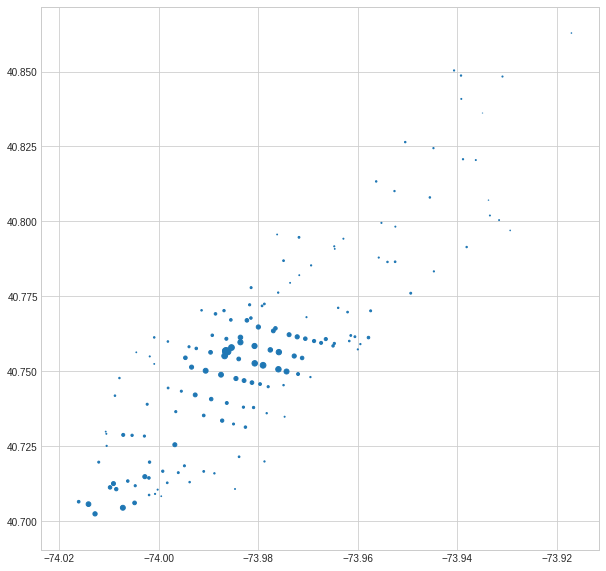

In [48]:
wname = "drive/My Drive/lwir/data/nyc_ratio/ny_wac_S000_JT00_2017.csv"
rname = "drive/My Drive/lwir/data/nyc_ratio/ny_rac_S000_JT00_2017.csv"
wdata = pd.read_csv(wname)
rdata = pd.read_csv(rname)
wdata.rename(columns = {'w_geocode': 'GEOID10'}, inplace=True)
rdata.rename(columns = {'h_geocode': 'GEOID10'}, inplace=True)
lehd = pd.merge(wdata[["GEOID10", "C000"]], rdata[["GEOID10", "C000"]], 
               on="GEOID10", suffixes=["_w", "_h"], how="outer").fillna(0)
lehd["total_p"] = lehd["C000_w"] + lehd["C000_h"]

dpath   = os.path.join("drive", "My Drive", "lwir", "data", "nyc_ratio", "tl_2019_36_tabblock10/tl_2019_36_tabblock10.shp")
ct_full = gp.read_file(dpath)

# -- convert geographic ID to integer
ct_full["GEOID10"] = ct_full["GEOID10"].astype(int)

# -- sub-select only New York City Counties
cnums  = ["005", "047", "061", "081", "085"]
ind    = ct_full.COUNTYFP10.isin(cnums)
ct_nyc = ct_full[ind]

# -- merge LEHD data and geographic data
lehd_ct = ct_nyc.merge(lehd, on="GEOID10")
print("init w+r epsg: ", lehd_ct.geometry.crs)
convert_to_nyc(lehd_ct)
print("converted w+r epsg: ", lehd_ct.geometry.crs)
wrtot = np.zeros(cam_len)
for i in range(cam_len):
  wrtot[i] = integrate_geodata(lehd_ct.geometry, lehd_ct.total_p, camera.lat[i], 
                                camera.lon[i], 500.)
plt.figure(figsize=(10, 10))
plt.scatter(camera.lon, camera.lat, s=wrtot/1000.)


**3.get the integrated number of counts between 8AM and 10AM**

In [66]:
def integrate_time_series(camera, start_index, end_index):
  result = []
  for j in range(len(camera)): 
    sum = 0 
    for i in range(start_index, end_index):
      sum += camera.iat[j,i]
    result.append(sum)
  return result

#eight_to_ten = 0
#print(camera.head())
#for i in range(len(camera)):
#  for j in range(35,43):         #35 因为camera最前面还有3个column:cam_id, lat, lon， 然后才是0，1，2，... 8点的index本应该是32, 加上3就是35
#    eight_to_ten += camera.iat[i,j]
#print(eight_to_ten)
eight_ten = integrate_time_series(camera, 35, 43) 
print(eight_ten)

[11.111751510138607, 34.374442940571974, 2.546037296037296, 36.92118472924925, 14.659260094743967, 13.770917254788223, 19.062420733388475, 61.92432424206618, 17.537738426448104, 41.02175226207484, 74.28446750382234, 64.29841592099656, 55.99176253853673, 42.618597889565635, 65.1651552748327, 11.784388550517583, 6.467908614682809, 14.85019299696719, 1.4283906058099605, 3.4536895004636943, 34.26181041181041, 8.189053061633707, 10.55967491290072, 68.52835802190643, 7.920760959470636, 13.69357345163797, 29.64505439005439, 8.906857658470562, 47.593060881770555, 22.10491265007394, 49.85218249492442, 50.808482467353436, 11.975077073464169, 11.50308231195328, 56.28841516906033, 29.302203799784444, 96.15331541218637, 32.49900995062285, 52.17549001178034, 29.113081184048927, 25.008194225129706, 30.528644384289542, 98.95350966238064, 15.31905558599107, 18.783993157380255, 6.314617640424092, 31.788407023084446, 9.353886883725593, 9.326522044263978, 35.024469258340226, 17.074939845101138, 0.31972328

**4.get the integrated number of counts between 11AM and 1PM**

In [67]:
#eleven_to_thirteen = 0
#for i in range(len(camera)):
  #for j in range(47,55): 
    #eleven_to_thirteen += camera.iat[i,j]
    

eleven_thirteen = integrate_time_series(camera, 47, 55)

print(eleven_thirteen)

3925.2674253460304
[18.529920885566046, 27.736396578332062, 2.3604802008027814, 30.631288961934125, 10.712969199259524, 9.745946526591688, 23.723715084198954, 67.01449339191275, 10.520597860920443, 44.91945885655563, 75.52365573494606, 64.07402892806118, 62.77109216947926, 40.70842088019507, 65.47385293917553, 13.993976990751184, 7.549163112872789, 17.354234385686, 1.0889724075207947, 2.78779598537663, 35.834028068705486, 8.142851950916466, 10.993908600360212, 55.97424493069654, 10.770469405146825, 16.662903494355106, 43.72002136752137, 11.12822786532464, 43.79366448963223, 32.17044541480025, 46.73947709996098, 40.470723541691285, 12.847234664976598, 9.850064362161136, 62.52578237175011, 30.752432066141743, 81.33377984023144, 35.726694004919814, 56.04823491920267, 31.190348719380975, 26.12955932955933, 24.30282369959789, 95.233991814637, 11.94904163936422, 19.351638952445402, 6.453471528471528, 29.324549285839606, 8.41022436345017, 12.015808474679442, 36.70766097701582, 18.490435371080

In [0]:
#plt.hist(rat, bins=100)

In [0]:
#print(np.median(rat))
#print(rat.std())


**5.get the integrated number of counts between 4PM and 6PM**

In [68]:
#sisteen_to_eighteen = 0
#for i in range(len(camera)):
#  for j in range(67,75): 
#    sisteen_to_eighteen += camera.iat[i,j]
#print(sisteen_to_eighteen)
sisteen_eighteen = integrate_time_series(camera, 67, 75)
print(sisteen_eighteen)

[23.192553324811385, 45.09090157154672, 3.0591823946662657, 34.49975938040454, 14.480086222021704, 15.798244228889393, 25.390768729478406, 77.66757525628493, 14.475879138782366, 59.19004937714615, 88.13618567812115, 83.57865754317366, 70.76968694388049, 51.983388475323956, 76.95973882748075, 13.81021505376344, 6.3221733463668945, 17.775489385166804, 2.509370378725217, 4.537465849562624, 37.689232273103244, 8.738225931774318, 13.217995087349927, 70.49592701205604, 13.551180539890215, 25.518090332606462, 44.850484330484335, 12.190728626212497, 50.26554126876708, 40.05682632779407, 63.22903727097275, 49.54774419129258, 14.924361480813094, 11.199680427099782, 71.52319597964758, 37.0382296914555, 87.29421009098428, 43.524554477780285, 61.28922600696794, 41.11709025741284, 31.93057372734792, 30.53045091109607, 91.22579517256936, 17.40230217810863, 21.72004536681956, 9.276667418602901, 43.52092387898839, 7.737630648920971, 14.83990400280723, 43.65908150988796, 24.598383337093015, 0.2748226683

23.821551753043433 25.001703346153064 29.94530288561365
20.888024255630807 21.376738696842896 25.08151663783873


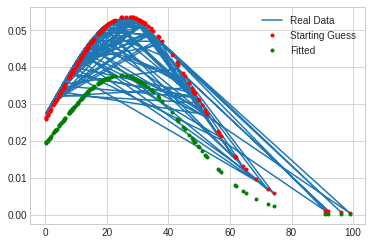

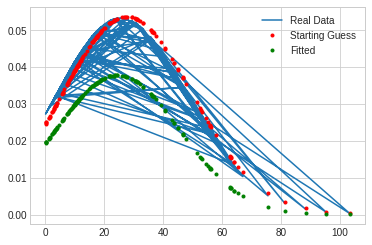

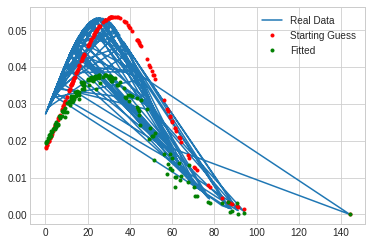

In [77]:
# eight_ten = integrate_time_series(camera, 35, 43) #integrated，list
# eleven_thirteen = integrate_time_series(camera, 47, 55)
# sisteen_eighteen = integrate_time_series(camera, 67, 75)
# print(eight_ten)
# print(eleven_thirteen)
# print(sisteen_eighteen)

######################################
# Setting up test data
def norm(x, mean, sd):
  norm = []
  for i in range(len(x)):
    norm.append(1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x[i] - mean)**2/(2*sd**2)))
  return np.array(norm)

mean1, mean2, mean3= statistics.mean(eight_ten), statistics.mean(eleven_thirteen), statistics.mean(sisteen_eighteen)
std1, std2, std3= statistics.stdev(eight_ten), statistics.stdev(eleven_thirteen), statistics.stdev(sisteen_eighteen) 

print(mean1, mean2, mean3)
print(std1, std2, std3)

y_real_1 = norm(eight_ten, mean1, std1) + norm(eight_ten, mean2, std2) + norm(eight_ten, mean3, std3)

######################################
# Solving
m, dm, sd1, sd2, sd3 = [24, 3, 21, 21, 25]
p = [m, dm, sd1, sd2, sd3] # Initial guesses for leastsq https://blog.csdn.net/weixin_37203756/article/details/80550886

def res(p, y, x):
  m, dm, sd1, sd2, sd3 = p
  m1 = m
  m2 = m1 + dm
  m3 = m2 + dm
  y_fit = norm(x, m1, sd1) + norm(x, m2, sd2) + norm(x, m3, sd3)
  err = y - y_fit
  return err

y_init = norm(eight_ten, m, sd1) + norm(eight_ten, m + dm, sd2) + norm(eight_ten, m + dm + dm, sd3)# For final comparison plot
plsq = leastsq(res, p, args = (y_real_1, eight_ten))
y_est = norm(eight_ten, plsq[0][0], plsq[0][2]) + norm(eight_ten, plsq[0][0] + plsq[0][1], plsq[0][3])

plt.plot(eight_ten, y_real_1, label='Real Data')
plt.plot(eight_ten, y_init, 'r.', label='Starting Guess')
plt.plot(eight_ten, y_est, 'g.', label='Fitted')
plt.legend()
plt.show()

m, dm, sd1, sd2, sd3 = [25, 3, 21, 21, 25]
p2 = [m, dm, sd1, sd2, sd3]

y_real_2 = norm(eleven_thirteen, mean1, std1) + norm(eleven_thirteen, mean2, std2) + norm(eleven_thirteen, mean3, std3)
y_init_2 = norm(eleven_thirteen, m, sd1) + norm(eleven_thirteen, m + dm, sd2) + norm(eleven_thirteen, m + dm + dm, sd3)# For final comparison plot
plsq = leastsq(res, p2, args = (y_real_2, eleven_thirteen))
y_est_2 = norm(eleven_thirteen, plsq[0][0], plsq[0][2]) + norm(eleven_thirteen, plsq[0][0] + plsq[0][1], plsq[0][3])

plt.plot(eleven_thirteen, y_real_2, label='Real Data')
plt.plot(eleven_thirteen, y_init_2, 'r.', label='Starting Guess')
plt.plot(eleven_thirteen, y_est_2, 'g.', label='Fitted')
plt.legend()
plt.show()


m, dm, sd1, sd2, sd3 = [30, 3, 21, 21, 25]
p3 = [m, dm, sd1, sd2, sd3]
y_real_3 = norm(sisteen_eighteen, mean1, std1) + norm(sisteen_eighteen, mean2, std2) + norm(sisteen_eighteen, mean3, std3)
y_init_3 = norm(sisteen_eighteen, m, sd1) + norm(sisteen_eighteen, m + dm, sd2) + norm(sisteen_eighteen, m + dm + dm, sd3)# For final comparison plot
plsq = leastsq(res, p3, args = (y_real_3, sisteen_eighteen))
y_est_3 = norm(eleven_thirteen, plsq[0][0], plsq[0][2]) + norm(sisteen_eighteen, plsq[0][0] + plsq[0][1], plsq[0][3])

plt.plot(sisteen_eighteen, y_real_3, label='Real Data')
plt.plot(sisteen_eighteen, y_init_3, 'r.', label='Starting Guess')
plt.plot(sisteen_eighteen, y_est_3, 'g.', label='Fitted')
plt.legend()
plt.show()

**Get the w and w+r within 500ft**

In [54]:
wname = "drive/My Drive/lwir/data/nyc_ratio/ny_wac_S000_JT00_2017.csv"
rname = "drive/My Drive/lwir/data/nyc_ratio/ny_rac_S000_JT00_2017.csv"
wdata = pd.read_csv(wname)
rdata = pd.read_csv(rname)
wdata.rename(columns = {'w_geocode': 'GEOID10'}, inplace=True)
rdata.rename(columns = {'h_geocode': 'GEOID10'}, inplace=True)
lehd = pd.merge(wdata[["GEOID10", "C000"]], rdata[["GEOID10", "C000"]], 
               on="GEOID10", suffixes=["_w", "_h"], how="outer").fillna(0)
lehd["total_p"] = lehd["C000_w"] + lehd["C000_h"]

dpath   = os.path.join("drive", "My Drive", "lwir", "data", "nyc_ratio", "tl_2019_36_tabblock10/tl_2019_36_tabblock10.shp")
ct_full = gp.read_file(dpath)

# -- convert geographic ID to integer
ct_full["GEOID10"] = ct_full["GEOID10"].astype(int)

# -- sub-select only New York City Counties
cnums  = ["061"]
ind    = ct_full.COUNTYFP10.isin(cnums)
ct_nyc = ct_full[ind]

# -- merge LEHD data and geographic data
lehd_ct = ct_nyc.merge(lehd, on="GEOID10")
print("init w+r epsg: ", lehd_ct.geometry.crs)
convert_to_nyc(lehd_ct)
print("converted w+r epsg: ", lehd_ct.geometry.crs)
wrtot_manhattan = np.zeros(cam_len)
working_manhattan = np.zeros(cam_len)
for i in range(cam_len):
  wrtot_manhattan[i] = integrate_geodata(lehd_ct.geometry, lehd_ct.total_p, camera.lat[i], 
                                camera.lon[i], 500.)
 
  working_manhattan[i] = integrate_geodata(lehd_ct.geometry, lehd_ct.C000_w, camera.lat[i], 
                                camera.lon[i], 500.)

init w+r epsg:  {'init': 'epsg:4269'}
converted w+r epsg:  {'init': 'epsg:2263', 'no_defs': True}


**1. Important Definition**

In [0]:
rat_w_wrtot = working_manhattan / wrtot_manhattan


eight_ten_array = np.array(eight_ten)
eleven_thirteen_array = np.array(eleven_thirteen)

rat_morning_lunch = eight_ten_array / eleven_thirteen_array
rat_lunch_morning = eleven_thirteen_array / eight_ten_array

**2. the ratio of lunch/morning as a function of w/(w+r), e.g., a scatterplot**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     5.340
Date:                Mon, 21 Oct 2019   Prob (F-statistic):             0.0222
Time:                        20:39:43   Log-Likelihood:                -16.891
No. Observations:                 157   AIC:                             37.78
Df Residuals:                     155   BIC:                             43.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4647      0.095      4.915      0.000       0.278       0.651
x1             0.1985      0.086      2.311      0.022       0.029       0.368
==============================================================================
Omnibus:                       33.435   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.080
Skew:                          -0.446   Prob(JB):                      0.00238
Kurtosis:                       1.974   Cond. No.                         8.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

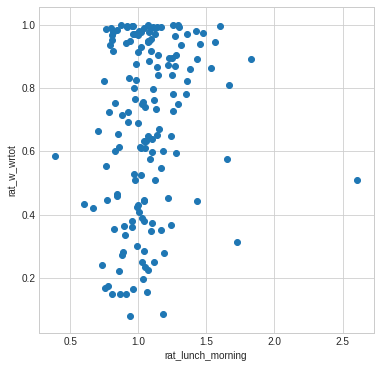

In [56]:
 #the ratio of lunch/morning as a function of w/(w+r), e.g., a scatterplot

rat_lunch_morning = eleven_thirteen_array / eight_ten_array
rat_w_wrtot = working_manhattan / wrtot_manhattan
# print(rat_lunch_morning)

fig, ax = plt.subplots(figsize=(6, 6))
plt.xlabel('rat_lunch_morning')
plt.ylabel('rat_w_wrtot')
plt.scatter(rat_lunch_morning, rat_w_wrtot)

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm



X = rat_lunch_morning
Y = rat_w_wrtot


X = sm.add_constant(X)
model = sm.OLS(Y,X)
fit = model.fit()
fit.summary()


**3. a scatter plot of lat/lon with the size of the point determined by the lunch/morning ratio**





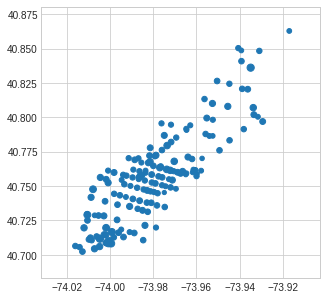

In [75]:

#N=157
#x = camera.lon
#y = camera.lat
#c = rat_lunch_morning
#s = rat_lunch_morning
#fig, ax = plt.subplots()
#scatter = ax.scatter(x, y, c=c, s=s)
#legend1 = ax.legend(*scatter.legend_elements(),
                    #loc="lower left", title="Classes")
#ax.add_artist(legend1)

plt.figure(figsize=(5, 5))

plt.scatter(camera.lon, camera.lat, s=rat_lunch_morning*30)


**4. the histogram of morning/afternoon**

(array([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 0.,
        5., 0., 2., 1., 1., 2., 2., 0., 1., 3., 3., 3., 7., 3., 3., 2., 4.,
        6., 2., 4., 3., 4., 5., 5., 8., 5., 3., 6., 4., 4., 4., 2., 3., 0.,
        5., 0., 0., 1., 1., 2., 2., 1., 1., 2., 4., 3., 2., 2., 0., 3., 2.,
        0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.33999397, 0.3509554 , 0.36191683, 0.37287826, 0.3838397 ,
        0.39480113, 0.40576256, 0.41672399, 0.42768542, 0.43864685,
        0.44960828, 0.46056971, 0.47153114, 0.48249257, 0.49345401,
        0.50441544, 0.51537687, 0.5263383 , 0.53729973, 0.54826116,
        0.55922259, 0.57018402, 0.58114545, 0.59210688, 0.60306832,
        0.61402975, 0.62499118, 0.63595261, 0.64691404, 0.65787547,
        0.6688369 , 0.67979833, 0.69075976, 0.70172119, 0.71268263,
        0.72364406, 0.73460549, 0.74556692, 0.75652835, 0.76748978,
      

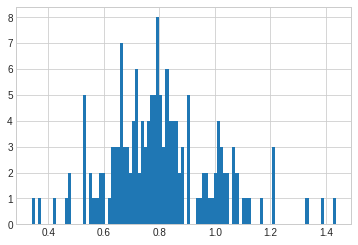

In [58]:
eight_ten_array = np.array(eight_ten)
sisteen_eighteen_array = np.array(sisteen_eighteen)
rat_morning_afternoon = eight_ten_array / sisteen_eighteen_array
plt.hist(rat_morning_afternoon, bins=100)

**5.fit each time series with a mixture of 3 Gaussians**

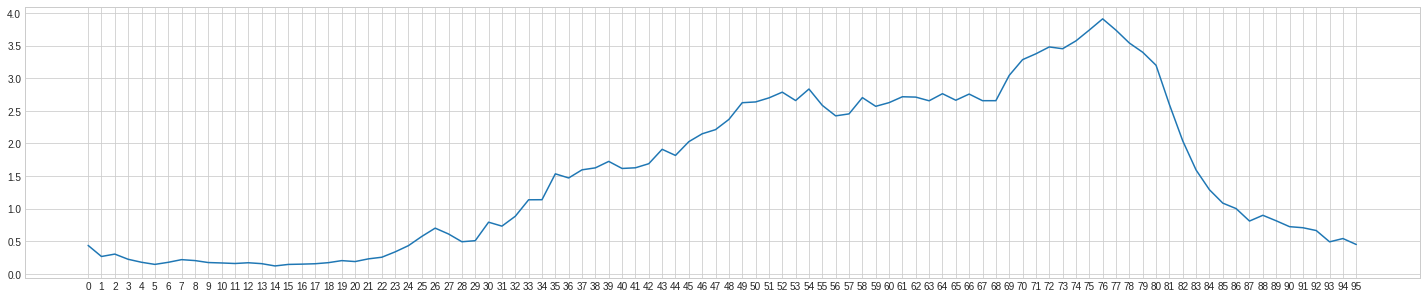

In [59]:
counts = camera.drop(columns=["cam_id", "lat", "lon"]).iloc[0].values
cols = camera.drop(columns=["cam_id", "lat", "lon"]).columns.values
plt.figure(figsize=(25, 5))

plt.xlabel('cols')
plt.ylabel('counts')

plt.scatter(cols, counts)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure(figsize=(25, 5))
ax = plt.axes()
ax.plot(cols, counts);

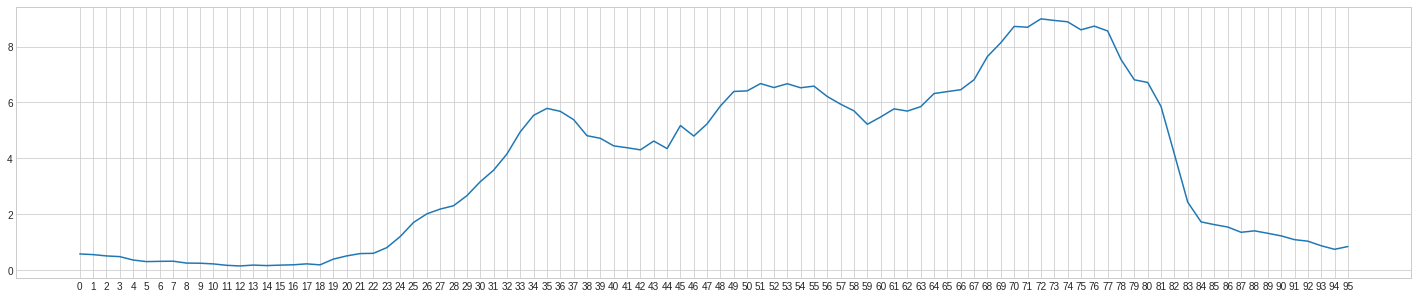

In [60]:
counts = camera.drop(columns=["cam_id", "lat", "lon"]).iloc[9].values
cols = camera.drop(columns=["cam_id", "lat", "lon"]).columns.values
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure(figsize=(25, 5))
ax = plt.axes()
ax.plot(cols, counts);

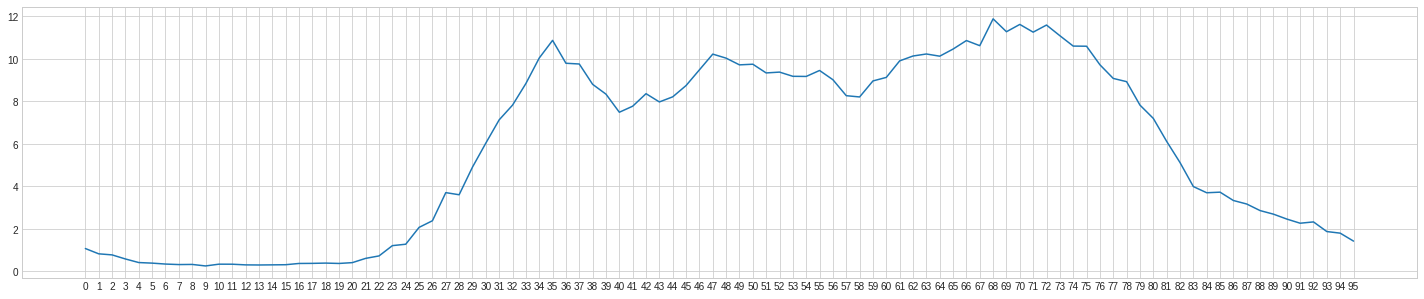

In [61]:
counts = camera.drop(columns=["cam_id", "lat", "lon"]).iloc[10].values
cols = camera.drop(columns=["cam_id", "lat", "lon"]).columns.values
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure(figsize=(25, 5))
ax = plt.axes()
ax.plot(cols, counts);

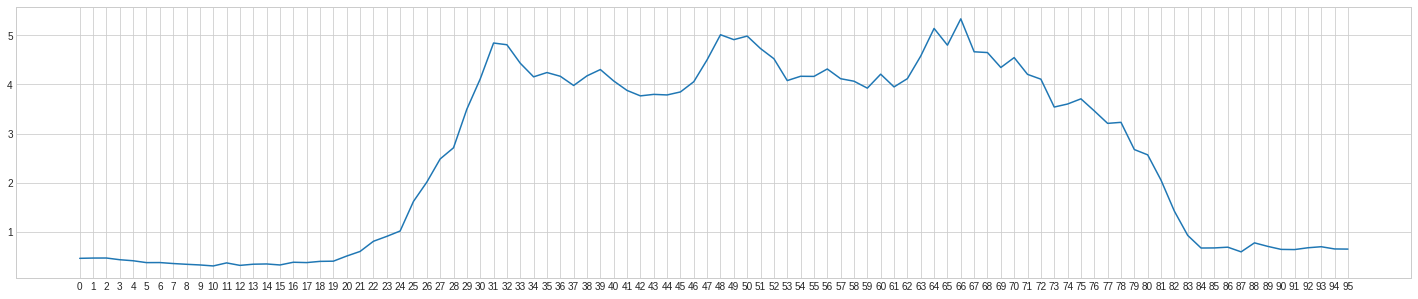

In [62]:
counts = camera.drop(columns=["cam_id", "lat", "lon"]).iloc[20].values
cols = camera.drop(columns=["cam_id", "lat", "lon"]).columns.values
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure(figsize=(25, 5))
ax = plt.axes()
ax.plot(cols, counts);

21.215812662049224 19.80510535859998 22.707639254413447
11.998633239030902 11.43205097016711 13.152388227335027


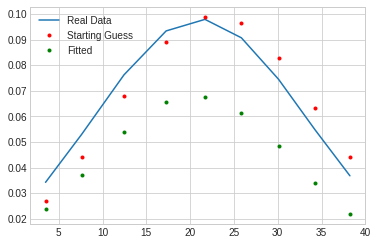

In [63]:
######################################
def integrate_time_series(camera, start_index, end_index):
  result = []
  j = 20
  sum = 0 
  for i in range(start_index, end_index+1):
    sum += camera.iat[j,i]
    result.append(sum)
  return result


eight_ten = integrate_time_series(camera, 32, 40) 
eleven_thirteen = integrate_time_series(camera, 44, 52)
sisteen_eighteen = integrate_time_series(camera, 64, 72)

# Setting up test data
def norm(x, mean, sd):
  norm = []
  for i in range(len(x)):
    norm.append(1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x[i] - mean)**2/(2*sd**2)))
  return np.array(norm)

mean1, mean2, mean3= statistics.mean(eight_ten), statistics.mean(eleven_thirteen), statistics.mean(sisteen_eighteen)
std1, std2, std3= statistics.stdev(eight_ten), statistics.stdev(eleven_thirteen), statistics.stdev(sisteen_eighteen) 

print(mean1, mean2, mean3)
print(std1, std2, std3)

y_real_1 = norm(eight_ten, mean1, std1) + norm(eight_ten, mean2, std2) + norm(eight_ten, mean3, std3)

m, dm, sd1, sd2, sd3 = [21, 2, 12, 11, 13]
p = [m, dm, sd1, sd2, sd3] # Initial guesses for leastsq https://blog.csdn.net/weixin_37203756/article/details/80550886

def res(p, y, x):
  m, dm, sd1, sd2, sd3 = p
  m1 = m
  m2 = m1 + dm
  m3 = m2 + dm
  y_fit = norm(x, m1, sd1) + norm(x, m2, sd2) + norm(x, m3, sd3)
  err = y - y_fit
  return err

y_init = norm(eight_ten, m, sd1) + norm(eight_ten, m + dm, sd2) + norm(eight_ten, m + dm + dm, sd3)# For final comparison plot
plsq = leastsq(res, p, args = (y_real_1, eight_ten))
y_est = norm(eight_ten, plsq[0][0], plsq[0][2]) + norm(eight_ten, plsq[0][0] + plsq[0][1], plsq[0][3])

plt.plot(eight_ten, y_real_1, label='Real Data')
plt.plot(eight_ten, y_init, 'r.', label='Starting Guess')
plt.plot(eight_ten, y_est, 'g.', label='Fitted')
plt.legend()
plt.show()



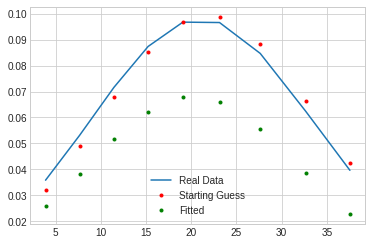

In [64]:
m, dm, sd1, sd2, sd3 = [20, 2, 12, 11, 13]
p2 = [m, dm, sd1, sd2, sd3]

y_real_2 = norm(eleven_thirteen, mean1, std1) + norm(eleven_thirteen, mean2, std2) + norm(eleven_thirteen, mean3, std3)
y_init_2 = norm(eleven_thirteen, m, sd1) + norm(eleven_thirteen, m + dm, sd2) + norm(eleven_thirteen, m + dm + dm, sd3)# For final comparison plot
plsq = leastsq(res, p2, args = (y_real_2, eleven_thirteen))
y_est_2 = norm(eleven_thirteen, plsq[0][0], plsq[0][2]) + norm(eleven_thirteen, plsq[0][0] + plsq[0][1], plsq[0][3])

plt.plot(eleven_thirteen, y_real_2, label='Real Data')
plt.plot(eleven_thirteen, y_init_2, 'r.', label='Starting Guess')
plt.plot(eleven_thirteen, y_est_2, 'g.', label='Fitted')
plt.legend()
plt.show()

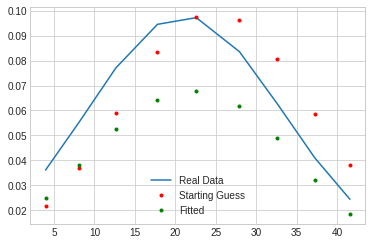

In [65]:
m, dm, sd1, sd2, sd3 = [23, 2, 12, 11, 13]
p3 = [m, dm, sd1, sd2, sd3]
y_real_3 = norm(sisteen_eighteen, mean1, std1) + norm(sisteen_eighteen, mean2, std2) + norm(sisteen_eighteen, mean3, std3)
y_init_3 = norm(sisteen_eighteen, m, sd1) + norm(sisteen_eighteen, m + dm, sd2) + norm(sisteen_eighteen, m + dm + dm, sd3)# For final comparison plot
plsq = leastsq(res, p3, args = (y_real_3, sisteen_eighteen))
y_est_3 = norm(eleven_thirteen, plsq[0][0], plsq[0][2]) + norm(sisteen_eighteen, plsq[0][0] + plsq[0][1], plsq[0][3])

plt.plot(sisteen_eighteen, y_real_3, label='Real Data')
plt.plot(sisteen_eighteen, y_init_3, 'r.', label='Starting Guess')
plt.plot(sisteen_eighteen, y_est_3, 'g.', label='Fitted')
plt.legend()
plt.show()